In [1]:
from astropy.coordinates import SkyCoord
from spherical_geometry import great_circle_arc, vector
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

### Defining functions

In [2]:
def polygon_area(lats, lons, algorithm = 0, radius = (180/np.pi)):
    """
    Computes area of spherical polygon, assuming spherical Earth.
    Returns result in ratio of the sphere's area if the radius is specified.
    Otherwise, in the units of provided radius.
    lats and lons are in degrees.

    Copied from https://stackoverflow.com/questions/31984047/python-work-out-area-of-a-polygon-on-a-spherical-surface
    """
    from numpy import arctan2, cos, sin, sqrt, pi, power, append, diff, deg2rad
    lats = np.deg2rad(lats)
    lons = np.deg2rad(lons)

    # Line integral based on Green's Theorem, assumes spherical Earth

    #close polygon
    if lats[0]!=lats[-1]:
        lats = append(lats, lats[0])
        lons = append(lons, lons[0])

    #colatitudes relative to (0,0)
    a = sin(lats/2)**2 + cos(lats)* sin(lons/2)**2
    colat = 2*arctan2( sqrt(a), sqrt(1-a) )

    #azimuths relative to (0,0)
    az = arctan2(cos(lats) * sin(lons), sin(lats)) % (2*pi)

    # Calculate diffs
    # daz = diff(az) % (2*pi)
    daz = diff(az)
    daz = (daz + pi) % (2 * pi) - pi

    deltas=diff(colat)/2
    colat=colat[0:-1]+deltas

    # Perform integral
    integrands = (1-cos(colat)) * daz

    # Integrate
    area = abs(sum(integrands))/(4*pi)

    area = min(area,1-area)
    if radius is not None: #return in units of radius
        return area * 4*pi*radius**2
    else: #return in ratio of sphere total area
        return area

In [9]:
def get_scale_factor(order, margin_thresh):
    resolution = hp.nside2resol(2 ** order, arcmin=True) / 60.
    scale = 1 + ((2 * margin_thresh) / resolution)
    return scale

In [10]:
def get_centroid(boundaries):
    n_samples = len(boundaries[0])
    centroid_lon = np.sum(boundaries[0]) / n_samples
    centroid_lat = np.sum(boundaries[1]) / n_samples
    return centroid_lon, centroid_lat


In [39]:
def transform_pixel_boundaries(pixel_boundaries, scale):
    n_samples = len(pixel_boundaries[0])
    centroid_lon, centroid_lat = get_centroid(pixel_boundaries)
    translate_lon = centroid_lon - (centroid_lon * scale)
    translate_lat = centroid_lat - (centroid_lat * scale)

    affine_matrix = np.array([[scale, 0, translate_lon],
                              [0, scale, translate_lat],
                              [0, 0, 1]])

    homogeneous = np.ones((3, n_samples))
    homogeneous[0] = pixel_boundaries[0]
    homogeneous[1] = pixel_boundaries[1]

    transformed_bounding_box = np.matmul(affine_matrix, homogeneous)
    for i in range(len(transformed_bounding_box[1])):
        dec = transformed_bounding_box[1][i]
        if dec > 90.0:
            transformed_bounding_box[1][i] = 90.0 - (dec - 90.0)
            transformed_bounding_box[0][i] = 180.0 + transformed_bounding_box[0][i]
        elif dec < -90.0:
            transformed_bounding_box[1][i] = -90.0 - (dec + 90.0)
            transformed_bounding_box[0][i] = 180.0 + transformed_bounding_box[0][i]
    return transformed_bounding_box

In [70]:
def get_closest_distance(point, points2):
    """return separation to closes point to point in points2"""
    osc = SkyCoord(point[0], point[1], unit='deg')
    tsc = SkyCoord(points2[0], points2[1], unit='deg')
    dist = tsc.separation(osc)
    min_dist = min(dist)
    return min_dist.dms.d + min_dist.dms.m/60 + min_dist.dms.s/3600

def plot_distances(point, points2):
    """Plot separation to point for each point in points2"""
    osc = SkyCoord(point[0], point[1], unit='deg')
    tsc = SkyCoord(points2[0], points2[1], unit='deg')
    dist = tsc.separation(osc)
    plt.plot(dist)

def get_closest_distances(points1, points2):
    """
    return array for each point in points1 the separation to the closest point in points2
    """
    dists = []
    for i in range(len(points1[0])):
        a = points1[0][i]
        b = points1[1][i]
        dists.append(get_closest_distance([a,b], points2))
    return dists


## Plot pixel and spherical quadrilateral approximation

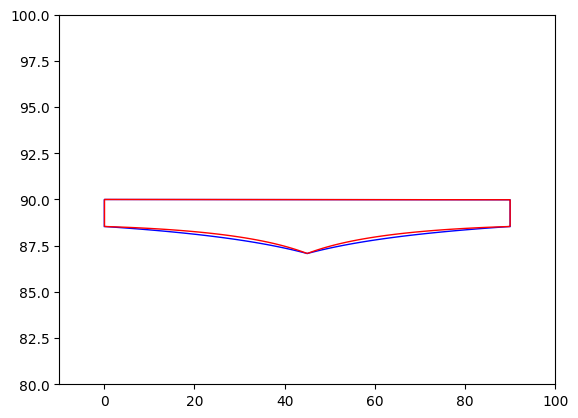

In [5]:
ax2 = plt.subplot(1, 1, 1)
order = 5
pixel = 1023

# Plot hp pixel bounds
nsides = hp.order2nside(order)
pix0_bounds = hp.vec2dir(hp.boundaries(nsides, pixel, step=100, nest=True), lonlat=True)
lon = pix0_bounds[0]
lat = pix0_bounds[1]
vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
p = Polygon(vertices, closed=True, edgecolor='blue', facecolor='none')
ax2.add_patch(p)

# Plot sphere approximations
pix0_corners_vec = hp.boundaries(nsides, pixel, step=1, nest=True)
vertices = np.vstack([pix0_corners_vec[0].ravel(), pix0_corners_vec[1].ravel(),pix0_corners_vec[2].ravel()]).transpose()
pix0_square_bounds = np.array([0, 2], dtype='float64')
for i in range(len(vertices)):
    a = vertices[i]
    b = vertices[(i+1) % 4]
    pix0_square_points = great_circle_arc.interpolate(a, b, steps=100)
    x, y, z = pix0_square_points.transpose()
    pix0_square_ra_dec = vector.vector_to_radec(x, y, z)
    pix0_square_verts = np.vstack([pix0_square_ra_dec[0].ravel(), pix0_square_ra_dec[1].ravel()]).transpose()
    p = Polygon(pix0_square_verts, closed=False, edgecolor='red', facecolor='none')
    ax2.add_patch(p)

plt.xlim(-10, 100)
plt.ylim(80, 100)
plt.show()

## Plot distance from center to edge of pixel vs resolution and compare to approx

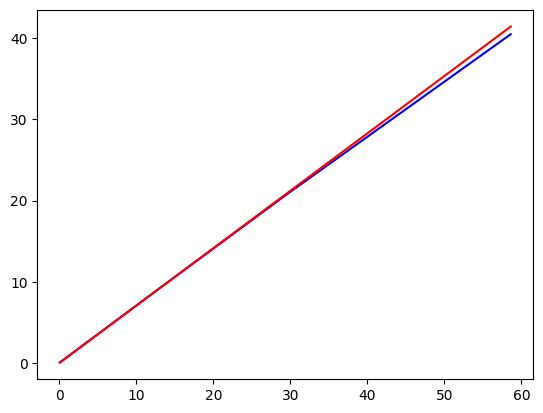

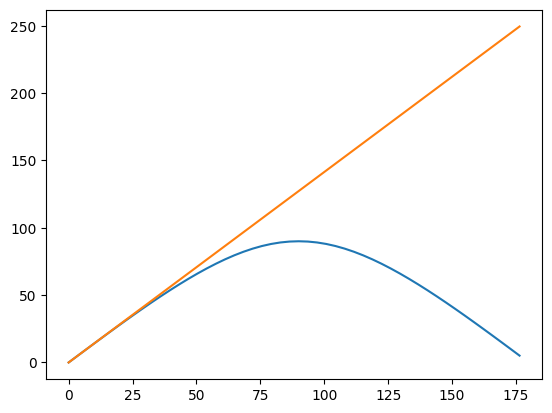

In [6]:
areas = []

for order in range(10,-1, -1):
    areas.append(hp.nside2pixarea(hp.order2nside(order), degrees=True))
res = np.sqrt(areas)

# Plot great circle distance from center to edge of pixel and approximation
square_point = SkyCoord(res/2, res/2, unit='deg')
origin = SkyCoord(0, 0, unit='deg')
angle_to_points = origin.separation(square_point) # formula for this distance = arccos(cos^2(res/2)) which is surprisingly close to linear for even pretty large angles
cartesian_approx = np.sqrt(2) * (1/2) * res
plt.plot(res, angle_to_points, 'b')
plt.plot(res, cartesian_approx, 'r')
plt.show()

# Plot distance function over 0-180 deg
x = np.arange(0, np.pi, np.pi/50)
y = np.arccos(np.cos(x)**2)
x = x * (180/np.pi)
y = y * (180/np.pi)
plt.plot(x, y)
plt.plot(x, np.sqrt(2)*x)
plt.show()

## Plot pixel bounds and work out area scaling

Order: 5, Pixel:50
actual area * scale factore squared: 4.1300783486990476, transformed bounds area: 4.13004163374743
mean margin sep: 0.11506806729499194 deg, max: 0.15013097300543704 deg min:0.09952052313628101 deg

Order: 5, Pixel:1023
actual area * scale factore squared: 4.1300783486990476, transformed bounds area: 3.9667396997800077
mean margin sep: 0.11552623445898597 deg, max: 0.15960418968035112 deg min:0.09633434560104483 deg

Order: 5, Pixel:1021
actual area * scale factore squared: 4.1300783486990476, transformed bounds area: 4.109083812052126
mean margin sep: 0.121335109380101 deg, max: 0.17975539478222743 deg min:0.07195642313283519 deg



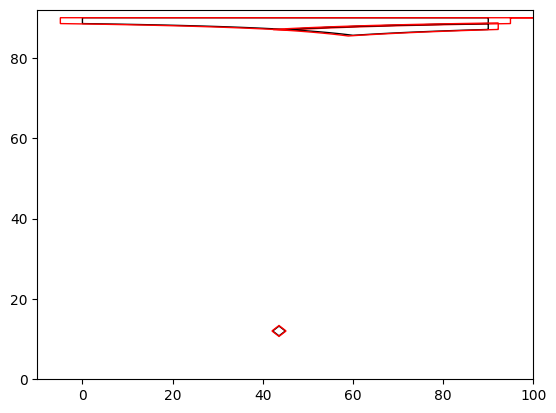

Order: 5, Pixel:50
actual area * scale factore squared: 4.1300783486990476, transformed bounds area: 4.13004163374743
mean margin sep: 0.11506806729499194 deg, max: 0.15013097300543704 deg min:0.09952052313628101 deg

Order: 5, Pixel:1023
actual area * scale factore squared: 4.1300783486990476, transformed bounds area: 3.9667396997800077
mean margin sep: 0.11552623445898597 deg, max: 0.15960418968035112 deg min:0.09633434560104483 deg

Order: 5, Pixel:1021
actual area * scale factore squared: 4.1300783486990476, transformed bounds area: 4.109083812052126
mean margin sep: 0.121335109380101 deg, max: 0.17975539478222743 deg min:0.07195642313283519 deg



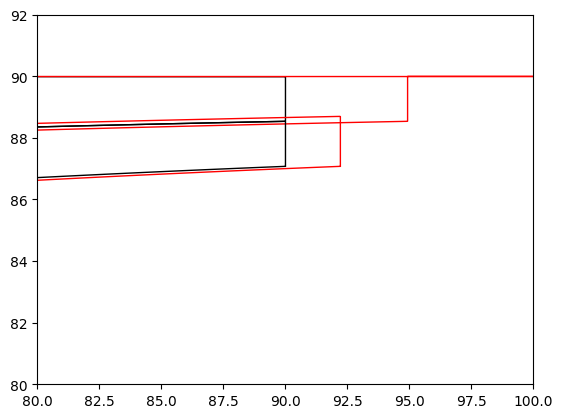

In [7]:
k = 5
margin_thresh = 0.1
step = 100

def plot_pixels(ax):
    for pix in [50,1023,1021]:
        scale = get_scale_factor(k, margin_thresh)
        pixel_area = hp.pixelfunc.nside2pixarea(2 ** k, degrees=True)

        pixel_boundaries = hp.vec2dir(hp.boundaries(2 ** k, pix, step=step, nest=True), lonlat=True)

        transformed_bounding_box = transform_pixel_boundaries(pixel_boundaries, scale)

        transformed_bounds_area = polygon_area(transformed_bounding_box[1], transformed_bounding_box[0], radius=(180/np.pi))
        print(f"Order: {k}, Pixel:{pix}")
        print(f"actual area * scale factore squared: {pixel_area * scale**2}, transformed bounds area: {transformed_bounds_area}")
        osc = SkyCoord(pixel_boundaries[0], pixel_boundaries[1], unit='deg')
        tsc = SkyCoord(transformed_bounding_box[0], transformed_bounding_box[1], unit='deg')
        dist = osc.separation(tsc)
        print(f"mean margin sep: {np.mean(dist)}, max: {np.max(dist)} min:{np.min(dist)}\n")

        lon = pixel_boundaries[0]
        lat = pixel_boundaries[1]
        vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
        p = Polygon(vertices, closed=True, edgecolor='black', facecolor='none')
        lon = transformed_bounding_box[0]
        lat = transformed_bounding_box[1]
        vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
        p2 = Polygon(vertices, closed=True, edgecolor='red', facecolor='none')
        ax.add_patch(p)
        ax.add_patch(p2)

axis = plt.subplot(1, 1, 1)

plot_pixels(axis)

plt.xlim(-10, 100)
plt.ylim(0, 92)
plt.show()

axis = plt.subplot(1, 1, 1)

plot_pixels(axis)

plt.xlim(80, 100)
plt.ylim(80, 92)
plt.show()

## Plot seperation over pixel edges

pixel at 45.0, 0.2984182167989483


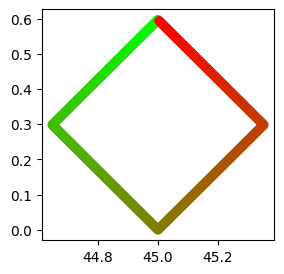

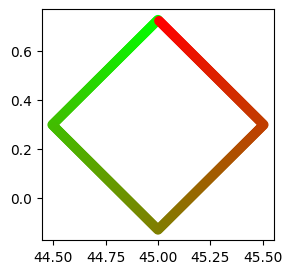

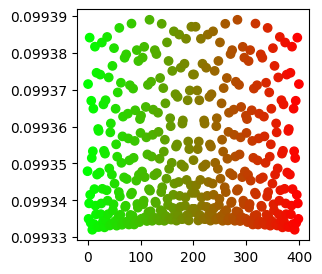

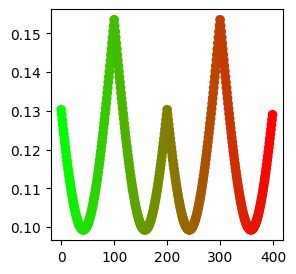

0.09933199371330276 1.653605093190806e-05


In [77]:
k = 7
pix = 0 # pixel near dec = 0
# pix = 4 ** k - 1 # pixel near dec = 0
margin_thresh = 0.1
step = 100

scale = get_scale_factor(k, margin_thresh)

pixel_boundaries = hp.vec2dir(hp.boundaries(2 ** k, pix, step=step, nest=True), lonlat=True)

centroid_lon, centroid_lat = get_centroid(pixel_boundaries)

print(f"pixel at {centroid_lon}, {centroid_lat}")

transformed_bounding_box = transform_pixel_boundaries(pixel_boundaries, scale)

osc = SkyCoord(pixel_boundaries[0], pixel_boundaries[1], unit='deg')
tsc = SkyCoord(transformed_bounding_box[0], transformed_bounding_box[1], unit='deg')
old_dist = osc.separation(tsc)

dist = get_closest_distances(pixel_boundaries, transformed_bounding_box)

r = np.arange(0, 255, step=255/len(pixel_boundaries[0]))
b = np.arange(255, 0, step=-255/len(pixel_boundaries[0]))
g = np.zeros(len(pixel_boundaries[0]))
c = np.vstack([r.ravel(), b.ravel(), g.ravel()]).transpose()

# plot original pixel bounds
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(pixel_boundaries[0], pixel_boundaries[1], c=c/255)
plt.show()

# plot transformed pixel bounds
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(transformed_bounding_box[0], transformed_bounding_box[1], c=c/255)
plt.show()

# plot separation to nearest point in bounded polygon
fig, ax = plt.subplots(figsize=(3,3))
inds = np.arange(0, len(pixel_boundaries[0]))
ax.scatter(inds, dist, c=c/255)
plt.show()

# plot old separation metric to same index point in bounded polygon
fig, ax = plt.subplots(figsize=(3,3))
inds = np.arange(0, len(pixel_boundaries[0]))
ax.scatter(inds, old_dist, c=c/255)
plt.show()

# print min separation between boundary and transformed and std deviation of separations
print(min(dist), np.std(dist))